---
title: 均值回归策略在A股ETF市场获利的可能性
description: 算法交易的一些尝试
author: 王一刀
categories: [量化交易]
date: 2024-09-24
format: html
---

### 如何在股票市场获利
曾经有人告诉我一个在股票市场赚钱的秘诀，只要掌握这个秘诀，赚钱就像捡钱一样容易。他说：这个秘诀其实很简单，就是在股票价格低的时候买入，在价格高的时候卖出。

啧啧，不愧是秘诀，明明是句废话，但又挑不出毛病。

问题是，如何判断价格是低还是高？我知道你想说：价值。低于价值就是低，高于价值就是高。但是，如何估算出它的价值？我知道现在估值方法一大对，公式指标漫天飞，但是任何公式任何指标都是参考都不能直接用。而当你无法准确估算价值时，其他的都无从谈起。至于股神的“价值投资”，你说它是艺术也好，说它是玄学也罢，都不是我等凡人能搞明白的。

既然是凡人，那就要用凡人的方法。如果公式太复杂让人摸不着头脑，如果指标太多让人无所适从，那就都不用，我们就简单粗暴地求平均值。当然，也不能随便什么股票拿过来就求平均值，我们得挑，挑那种上下波动的股票，不要一路跌，也不要一路涨(我知道你可能青睐这种股票，但是这种股票不适合均值回归)。用统计学中的术语就是平稳，我们目标就是要寻找那种价格在时间序列上表现平稳的股票。

我们找到价格平稳的股票之后，还要弄清楚，它是多长时间从低点到高点然后又回到高点，就是周期。有两个原因：1.我们要把周期太长的抛弃，你也不想等5年挣1%吧。2.我们尽量在一个周期内完成一次买卖操作，不要错过周期，它一年低点到高点波动10次，你就买卖一次，那就有点辜负人家的好意了。

接下来，我们就需要解决这两个问题：平稳性和周期。

### 平稳性测试
我打算使用ETF的数据来测试，因为ETF关联的是一篮子股票，和单只股票相比应该更平稳，更符合我们的意图。(至于,自己挑选多只股票,以不同权重组合起来以达到平稳，那是另外一个问题了，以后有机会再议)所有的数据都通过akshare来获取，你可以访问akshare的官方网站获取更多信息。

使用Dickey-Fuller（迪基-富勒）检验判断股票价格序列的平稳性。至于迪基-富勒检测的原理，你可以自行搜索，也可以看我在这篇[关于迪基-富勒检验](https://wangxuan.me/doushuai/posts/2024-08-20-Things-About-Dickey-Fuller.html)[^1]整理的一些概念。

[^1]: https://wangxuan.me/doushuai/posts/2024-08-20-Things-About-Dickey-Fuller.html

我们先把A股所有ETF查出来，然后逐一检测。检测的时候仅获取2023年1月1日以后的数据，使用的是收盘价。

In [31]:
import akshare as ak
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

def adf_test(hist_data):
    results=adfuller(hist_data, maxlag=None, regression='c', autolag='AIC')
    # print('ADF Statistic: %f' % results[0])  
    # print('p-value: %f' % results[1])  
    # print('Critical Values:')  
    # for key, value in results[4].items():  
    #     print('\t%s: %.3f' % (key, value))  
    if results[1] > 0.05:
        # print("时间序列是非平稳的，p-value > 0.05")
        return False
    else:
        # print("时间序列是平稳的，p-value <= 0.05")
        return True
    
def process_row(row):
    # print(row)
    hist_data = ak.fund_etf_hist_sina(symbol=row['代码'])
    if 'date' not in hist_data.columns:
        print('date not in clolumns 代码:%s 名称:%s ' % (row['代码'],row['名称']))
        print(hist_data)
        return None
    hist_data.set_index('date',inplace=True)
    y=hist_data.loc[hist_data.index >= datetime.strptime('2023-01-01','%Y-%m-%d').date(), 'close']
    # print(y)
    if len(hist_data) < 15:
        # print('代码:%s 名称:%s ' % (row['代码'],row['名称']))
        # print(f"Data length: {len(y)}")
        return None
    if adf_test(y):
         print('代码:%s 名称:%s 时间序列adf测试结果是平稳的' % (row['代码'],row['名称']))
         return row['代码'],row['名称']
    else:
        return None
# 获取所有ETF基金信息
fund_etf_category_sina_df = ak.fund_etf_category_sina(symbol="ETF基金")
# 对所有基金做DF测试
results = fund_etf_category_sina_df.apply(process_row,axis=1).dropna()
p_results = [r for r in results if r is not None]
results_df = pd.DataFrame(p_results, columns=['代码', '名称'])
print(results_df)
# 将结果保存到csv
results_df.to_csv('datas/eft_fund_stationary_results.csv', index=False)


代码:sz159939 名称:信息技术ETF 时间序列adf测试结果是平稳的
代码:sz159933 名称:国投金融地产ETF 时间序列adf测试结果是平稳的
代码:sz159811 名称:5G50ETF 时间序列adf测试结果是平稳的
代码:sz159607 名称:中概互联网ETF 时间序列adf测试结果是平稳的
代码:sz159605 名称:中概互联ETF 时间序列adf测试结果是平稳的
代码:sz159587 名称:粮食50ETF 时间序列adf测试结果是平稳的
代码:sz159579 名称:深主板50ETF华安 时间序列adf测试结果是平稳的
代码:sz159570 名称:港股通创新药ETF 时间序列adf测试结果是平稳的
代码:sz159569 名称:港股红利低波ETF 时间序列adf测试结果是平稳的
代码:sz159567 名称:港股创新药ETF 时间序列adf测试结果是平稳的
代码:sz159557 名称:恒生医疗指数ETF 时间序列adf测试结果是平稳的
代码:sz159552 名称:中证2000增强ETF 时间序列adf测试结果是平稳的
代码:sz159545 名称:恒生红利低波ETF 时间序列adf测试结果是平稳的
代码:sz159507 名称:电信ETF 时间序列adf测试结果是平稳的
代码:sz159331 名称:红利港股ETF 时间序列adf测试结果是平稳的
代码:sz159330 名称:沪深300ETF基金 时间序列adf测试结果是平稳的
代码:sz159329 名称:沙特ETF 时间序列adf测试结果是平稳的
代码:sz159005 名称:汇添富快钱ETF 时间序列adf测试结果是平稳的
代码:sz159003 名称:招商快线ETF 时间序列adf测试结果是平稳的
代码:sz159001 名称:货币ETF 时间序列adf测试结果是平稳的
代码:sh563180 名称:高股息ETF 时间序列adf测试结果是平稳的
代码:sh520830 名称:沙特ETF 时间序列adf测试结果是平稳的
代码:sh516110 名称:汽车ETF 时间序列adf测试结果是平稳的
代码:sh512640 名称:金融地产ETF基金 时间序列adf测试结果是平稳的
代码:sh512160 名称:MSCI中国A股ETF 时间序列adf测试结果是平稳的
代码:sh51

### 半衰期
下面的代码中，半衰期是通过对时间序列数据进行自回归分析（AR模型）得到的,这篇[关于迪基-富勒检验](https://wangxuan.me/doushuai/posts/2024-08-20-Things-About-Dickey-Fuller.html)的文章中也整理了一些概念。至于，为什么，我无法解释。如果你能解释，请给我留言。

In [32]:
import statsmodels.api as sm
import numpy as np

def get_halflife(y):
    ylag = y.shift() #创建一个滞后变量
    # print(ylag)
    deltay = y - ylag #计算收盘价的差分
    # print(deltay)
    deltay = deltay[1:] #删除第一个NaN值
    # print(deltay)

    # print(ylag[1:])
    X=sm.add_constant(ylag[1:]) # 为滞后变量添加常数项
    # print(X)
    model=sm.OLS(deltay, X) #创建一个线性回归模型
    res=model.fit() #拟合模型
    halflife=-np.log(2)/res.params.iloc[1] #计算半衰期
    print('halflife:',halflife)
    return halflife

stationary_df = pd.read_csv('datas/eft_fund_stationary_results.csv')

# 遍历每一行
for index, row in stationary_df.iterrows():
    print(f"Row index: {index}, Values: {row['代码']}, {row['名称']}")
    fund_etf_hist_sina_df = ak.fund_etf_hist_sina(symbol=row['代码'])
    # print(fund_etf_hist_sina_df)
    fund_etf_hist_sina_df.set_index('date',inplace=True)
    y=fund_etf_hist_sina_df.loc[fund_etf_hist_sina_df.index >= datetime.strptime('2022-01-01','%Y-%m-%d').date(), 'close']
    halflife = get_halflife(y)
    if halflife is not None:
        stationary_df.loc[index, '半衰期'] = halflife
        stationary_df.loc[index, '最高价'] = y.max()
        stationary_df.loc[index, '最低价'] = y.min()
    # print(stationary_df)
    
stationary_df.to_csv('datas/eft_fund_stationary_halflife.csv', index=False)

Row index: 0, Values: sz159939, 信息技术ETF
halflife: 92.34305228118055
Row index: 1, Values: sz159933, 国投金融地产ETF
halflife: 20.68724512575711
Row index: 2, Values: sz159811, 5G50ETF
halflife: 26.37190816021413
Row index: 3, Values: sz159607, 中概互联网ETF
halflife: 17.28790422641463
Row index: 4, Values: sz159605, 中概互联ETF
halflife: 17.06493212981132
Row index: 5, Values: sz159587, 粮食50ETF
halflife: 2.949089109871738
Row index: 6, Values: sz159579, 深主板50ETF华安
halflife: 2.813338527596978
Row index: 7, Values: sz159570, 港股通创新药ETF
halflife: 6.72602477892452
Row index: 8, Values: sz159569, 港股红利低波ETF
halflife: 6.982621873502573
Row index: 9, Values: sz159567, 港股创新药ETF
halflife: 5.551490912970278
Row index: 10, Values: sz159557, 恒生医疗指数ETF
halflife: 3.886180626825971
Row index: 11, Values: sz159552, 中证2000增强ETF
halflife: 1.6623555515355546
Row index: 12, Values: sz159545, 恒生红利低波ETF
halflife: 9.563267261024693
Row index: 13, Values: sz159507, 电信ETF
halflife: 15.354744585135212
Row index: 14, Values: sz1

我们进一步筛选一下，把半衰期太长(大于30)和太短(小于5)的抛弃。

In [33]:
target_df = pd.read_csv('datas/eft_fund_stationary_halflife.csv')

filtered_df = target_df[(target_df['半衰期'] > 5) & (target_df['半衰期'] < 30)].copy()

filtered_df.loc[:, '最大涨幅'] = (filtered_df['最高价'] - filtered_df['最低价']) / filtered_df['最低价']
# 按最大涨幅降序排序
sorted_df = filtered_df.sort_values(by='最大涨幅', ascending=False)
# pd.set_option('display.max_rows', 100)  # 设置最多显示100行
# 打印结果
print(sorted_df)

          代码          名称        半衰期    最高价    最低价      最大涨幅
3   sz159607    中概互联网ETF  17.287904  0.960  0.545  0.761468
4   sz159605     中概互联ETF  17.064932  0.957  0.545  0.755963
2   sz159811     5G50ETF  26.371908  1.281  0.771  0.661479
22  sh516110       汽车ETF  23.956387  1.312  0.828  0.584541
13  sz159507       电信ETF  15.354745  1.024  0.736  0.391304
23  sh512640   金融地产ETF基金  21.492513  2.110  1.564  0.349105
9   sz159567    港股创新药ETF   5.551491  1.004  0.754  0.331565
1   sz159933   国投金融地产ETF  20.687245  2.526  1.900  0.329474
7   sz159570   港股通创新药ETF   6.726025  0.923  0.753  0.225764
12  sz159545   恒生红利低波ETF   9.563267  1.132  0.977  0.158649
20  sh563180      高股息ETF  16.960360  1.036  0.933  0.110397
14  sz159331     红利港股ETF   5.127745  1.011  0.924  0.094156
8   sz159569   港股红利低波ETF   6.982622  1.016  0.939  0.082002
15  sz159330  沪深300ETF基金   6.224023  1.002  0.951  0.053628


上面对涨幅进行了排序，中概互联网ETF涨幅最大，我们来把数据拉出来验证一下

<Axes: xlabel='date'>

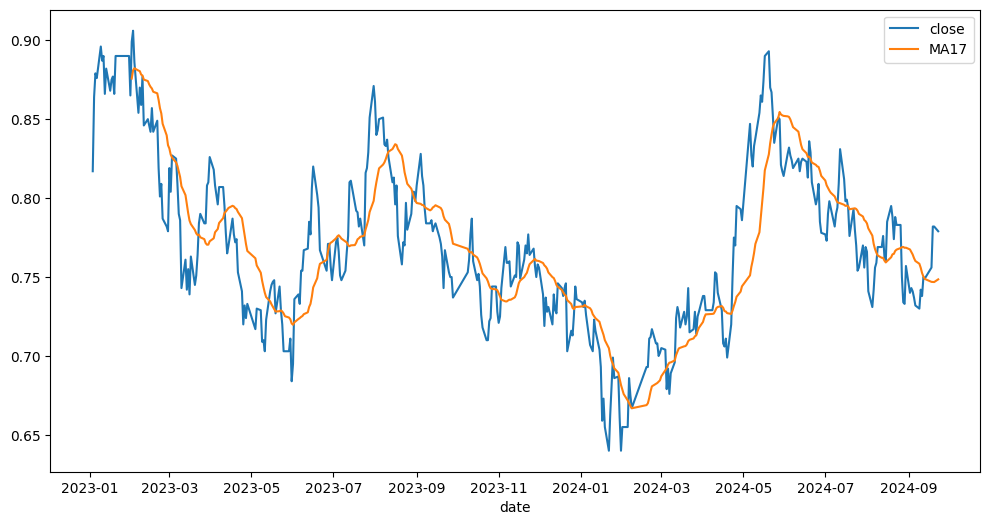

In [46]:
etf_df = ak.fund_etf_hist_sina(symbol='sz159607')
etf_df.set_index('date',inplace=True)
close_data=etf_df.loc[etf_df.index >= datetime.strptime('2023-01-01','%Y-%m-%d').date(), 'close'].to_frame()
# close_data.plot(figsize=(12, 6))
close_data['MA17'] = close_data.rolling(window=17).mean().ffill()
close_data.plot(y=['close', 'MA17'], figsize=(12, 6))

这个曲线看起来还可以，应该能挣到钱吧。回测下试试。

In [115]:
from datetime import datetime
import backtrader as bt
import pandas as pd

class SimpleMovingAverage(bt.Strategy):
    """
    主策略程序
    """
    params = (("maperiod", 17),)  # 全局设定交易策略的参数

    def __init__(self):
        """
        初始化函数
        """
        self.data_close = self.datas[0].close  # 指定价格序列
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buy_price = None
        self.buy_comm = None
        # 添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod
        )
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def next(self):
        """
        执行逻辑
        """
        if self.order:  # 检查是否有指令等待执行,
            return
        if self.data_close[0] > self.sma[0]:# 执行卖出条件判断：收盘价格高于日均线
            if self.position: # 检查是否持仓
                self.order = self.sell(size=20000)
        if self.data_close[0] < self.sma[0]: # 执行买入条件判断：收盘价格跌破日均线
            self.order = self.buy(size=20000)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                        order.executed.value,
                        order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        self.order = None

def get_data_byakshare(code,start_date,end_date):
    fund_etf_hist_sina_df = ak.fund_etf_hist_sina(symbol=code)
    df=fund_etf_hist_sina_df.loc[(fund_etf_hist_sina_df['date'] >= start_date) & (fund_etf_hist_sina_df['date'] <= end_date)]
    # print(df)
    df.columns = ['trade_date', 'open', 'high', 'low', 'close','volume']
    # df.loc[:, 'trade_date'] = pd.to_datetime(df['trade_date'])
    df.set_index('trade_date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # df.ffill()

    return df
cerebro = bt.Cerebro()

cerebro.addstrategy(SimpleMovingAverage)
start_date = datetime(2024, 3, 1)  # 回测开始时间
end_date = datetime(2024, 9, 1)  # 回测结束时间
stock_code = "sz159607"

data = get_data_byakshare(stock_code,start_date.date(),end_date.date())
datafeed = bt.feeds.PandasData(dataname=data,
                                fromdate=start_date,
                                todate=end_date)
cerebro.adddata(datafeed,name=stock_code)

cerebro.broker.setcash(100000.0)
# cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.002)

print('组合初始值: %.2f' % cerebro.broker.getvalue())

result=cerebro.run()

print('组合终结值: %.2f' % cerebro.broker.getvalue())
# cerebro.plot()


组合初始值: 100000.00
2024-04-16, BUY EXECUTED, Price: 0.71, Cost: 14300.00, Comm 28.60
2024-04-17, BUY EXECUTED, Price: 0.71, Cost: 14220.00, Comm 28.44
2024-04-18, BUY EXECUTED, Price: 0.71, Cost: 14120.00, Comm 28.24
2024-04-19, BUY EXECUTED, Price: 0.70, Cost: 14020.00, Comm 28.04
2024-04-22, BUY EXECUTED, Price: 0.71, Cost: 14140.00, Comm 28.28
2024-04-23, BUY EXECUTED, Price: 0.73, Cost: 14680.00, Comm 29.36
2024-04-24, SELL EXECUTED, Price: 0.76, Cost: 14246.67, Comm 30.36
2024-04-25, SELL EXECUTED, Price: 0.77, Cost: 14246.67, Comm 30.80
2024-04-26, SELL EXECUTED, Price: 0.77, Cost: 14246.67, Comm 30.96
2024-04-29, SELL EXECUTED, Price: 0.80, Cost: 14246.67, Comm 31.92
2024-04-30, SELL EXECUTED, Price: 0.80, Cost: 14246.67, Comm 31.80
2024-05-06, SELL EXECUTED, Price: 0.84, Cost: 14246.67, Comm 33.44
2024-05-27, BUY EXECUTED, Price: 0.84, Cost: 16800.00, Comm 33.60
2024-05-28, SELL EXECUTED, Price: 0.85, Cost: 16800.00, Comm 33.96
2024-05-29, BUY EXECUTED, Price: 0.84, Cost: 16760.0

3月1号到9月1号，10W的本金，折腾半年挣了6851，收益率6.8%，啧啧。怎么说呢，好像还真有点赚头…（其实，每次下单量对收益也有影响，我调整了几次，发现20000可能是收益最高的了，真实交易的时候是不会给我这种调整的机会的...还有，这策略每天都要操作，要玩起来可能还真的全职，但交易太频繁成本也高，佣金都要3000块了，交易成本占收益一半，还是慎重吧...）

上面的方法大都出自《算法交易》这本书。

刚看完这书的时候，我意气风发，都准备辞职在家全职炒股了。现在再看，半年挣6千...唉，还是算了，安心搬砖吧。